In [1]:
%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from operator import itemgetter
def print_public_attributes(obj):
    print(list([att for att in dir(obj) 
         if '__' not in att and not att.startswith('_')]))

In [2]:
c = Image.open('sample_images/chicago.jpg')
s = Image.open('sample_images/starry.jpg')

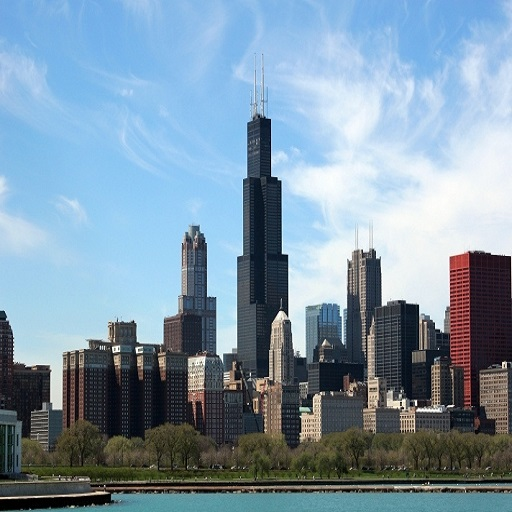

In [3]:
c

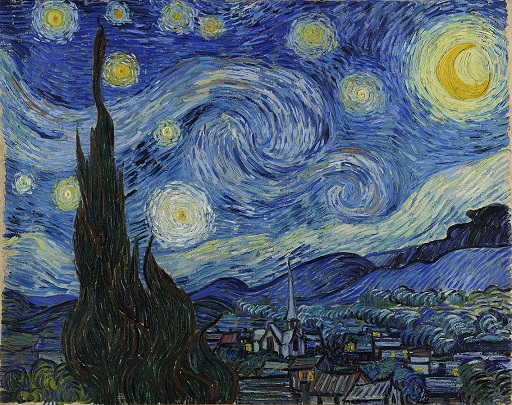

In [4]:
s

torch.Size([1, 512, 64, 64]) torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64]) torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64]) torch.Size([1, 512, 64, 64])


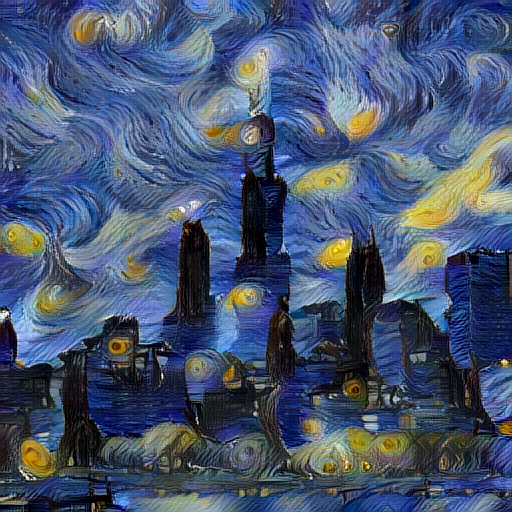

In [5]:
from model.model import Stylizer
net = Stylizer()
net(c,s,3)

In [6]:
from model.model import Encoder, Decoder, get_transformer

In [7]:
encoder = Encoder()
decoder = Decoder()
trfm = get_transformer()
encoder.requires_grad = False
decoder.requires_grad = False
trfm.requires_grad = False

In [8]:
PT_IMG_SIZE = [1,3,256,256]
TF_IMG_SIZE = [1,256,256,3]

Fixed a major bug. In Model.py there was a statement like `b, c, h, w = H.size()` followed by ` H = H.view(b, -1, h * w)`. During the conversion process to ONNX, the ONNX translator made these values into constants. So, if I were to input image of other size, the same BCHW would be used and cause a problem during a reshape. So, I replaced these statements with `torch.flatten` instead. Which dynamically determines the resulting shape, thereby fixing this subtle bug. 

In [9]:
iters = 1
dummy_content = torch.randn([1,3,512,270], device='cpu')
dummy_style = torch.randn([1,3,512,270], device='cpu')

with torch.no_grad():
    c4_1 = dummy_content.detach().clone()
    s4_1 = dummy_style.detach().clone()
    for _ in range(iters):
        out = encoder(c4_1)
        torch.onnx.export(encoder, c4_1, 
                          'encoder.onnx',
                          input_names=['image'],
                          output_names=['out4_1','out5_1'],
                          dynamic_axes=dict(
                            image=[2,3],
                            out4_1=[2,3],
                            out5_1=[2,3]
                          ),
                          do_constant_folding=False,
                          opset_version=10
                         )
        print('encoder out')
        c4_1, c5_1 = out
        s4_1, s5_1 = encoder(s4_1)

        c_tfm = trfm(c4_1, s4_1, c5_1, s5_1)
        
        torch.onnx.export(trfm, (c4_1, s4_1, c5_1, s5_1),
                          'transform.onnx',
                          input_names=['c4_1', 's4_1', 'c5_1', 's5_1'],
                          dynamic_axes=dict(
                            c4_1=[2,3],
                            s4_1=[2,3],
                            c5_1=[2,3],
                            s5_1=[2,3],
                            c_tfm=[2,3],
                          ),
                          opset_version=10,
                          do_constant_folding=False,
                          output_names=['c_tfm',],
                          # verbose=True
                         )
        print('tfrm out')
        
        c_stylized = decoder(c_tfm)
        
        torch.onnx.export(decoder, c_tfm,
                         'decoder.onnx',
                          input_names=['c_tfm'],
                          dynamic_axes=dict(
                            c_tfm=[2,3],
                            c_stylize=[2,3],
                          ),
                          opset_version=10,
                          do_constant_folding=False,
                          output_names=['c_stylized'],
                         )
        print('decoder out')
        
        # c4_1 = c_stylized.detach().clone()
        # s4_1 = dummy_style.detach().clone()

# dummy_input = enc_model(dummy_input)
# trf_model = net.transform().cuda()
# dec_model = net.decoder.cuda()
# torch.onnx.export(dec_model,
#                   dummy_input,
#                   'decoder.onnx', 
#                   input_names=['encoded'],
#                  opset_version=11)

c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input image
  warnings.warn("No names were found for specified dynamic axes of provided input."
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input out4_1
  warnings.warn("No names were found for specified dynamic axes of provided input."
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input out5_1
  warnings.warn("No names were found for specif

encoder out
torch.Size([1, 512, 64, 34]) torch.Size([1, 512, 64, 34])


c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input c4_1
  warnings.warn("No names were found for specified dynamic axes of provided input."
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input s4_1
  warnings.warn("No names were found for specified dynamic axes of provided input."
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input c5_1
  warnings.warn("No names were found for specified d

torch.Size([1, 512, 64, 34]) torch.Size([1, 512, 64, 34])


c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\symbolic_helper.py:381: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "


tfrm out


c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1294: UserWarning: Provided key c_stylize for dynamic axes is not a valid input/output name
  warnings.warn("Provided key {} for dynamic axes is not a valid input/output name".format(key))
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\utils.py:1296: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input c_stylize
  warnings.warn("No names were found for specified dynamic axes of provided input."


decoder out


In [10]:
# !git clone --depth 1 https://github.com/onnx/onnx-tensorflow.git
# !pip install -e onnx-tensorflow

In [11]:
import onnxruntime as ort
import onnx

In [12]:
def run_onnx(model_path, **kwargs):
    kwargs = {k:np.array(v) for k,v in kwargs.items()}
    out = ort.InferenceSession(model_path)\
        .run(None,input_feed=kwargs)    
    return out

In [13]:
# crop = T.RandomCrop(PT_IMG_SIZE[2:],pad_if_needed=True,padding_mode='reflect')
# resize = T.Resize(PT_IMG_SIZE[2:])
batch_dim = T.Lambda(lambda x:x[None,...])
to_tensor = T.ToTensor()

# content_tfm = T.Compose((resize, to_tensor, batch_dim))
# style_tfm = T.Compose((resize, to_tensor, batch_dim))

iters = 2
c_inp = torch.randn(1,3,512,512)#content_tfm(c)
s_inp = torch.randn(1,3,512,512)#style_tfm(s)

with torch.no_grad():
    c4_1 = c_inp.detach().clone()
    s4_1 = s_inp.detach().clone()
    for _ in range(iters):
        c4_1, c5_1 = run_onnx('encoder.onnx', image=c4_1)
        s4_1, s5_1 = run_onnx('encoder.onnx', image=s4_1)
        (c_tfm,) = run_onnx('transform.onnx', c4_1=c4_1,
                         s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
        (c_stylized,) = run_onnx('decoder.onnx', c_tfm=c_tfm)
        c4_1 = c_stylized#.detach().clone()
        s4_1 = s_inp#.detach().clone()
        c4_1 = c4_1.clip(0,1)

In [14]:
from pathlib import Path
from onnx_tf.backend import prepare
model_files = ['decoder.onnx','encoder.onnx','transform.onnx']
tf_files = []
for file in model_files:
    print(f'converting {file}')
    onnx_model = onnx.load(file,)  # load onnx model
    tf_rep = prepare(onnx_model,)  # prepare tf representation
    tf_model_path = f"model/weights/tf/{Path(file).stem}"
    tf_rep.export_graph(tf_model_path)  # export the model
    tf_files.append(tf_model_path)
    !onnx-tf convert -i {file} -o {tf_model_path}
    # break
# prepare()
# print_public_attributes(tf_rep)
# tf_rep.o

c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


converting decoder.onnx


INFO:tensorflow:Assets written to: model/weights/tf/decoder\assets


INFO:tensorflow:Assets written to: model/weights/tf/decoder\assets
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-13 04:09:37,679 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-02-13 04:10:02.820685: W tensorflow/python/util/util.cc:368] Sets are not currently cons

converting encoder.onnx


INFO:tensorflow:Assets written to: model/weights/tf/encoder\assets


INFO:tensorflow:Assets written to: model/weights/tf/encoder\assets
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-13 04:10:21,241 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-02-13 04:10:30.559338: W tensorflow/python/util/util.cc:368] Sets are not currently cons

converting transform.onnx


INFO:tensorflow:Assets written to: model/weights/tf/transform\assets


INFO:tensorflow:Assets written to: model/weights/tf/transform\assets
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-13 04:10:54,644 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-02-13 04:11:09.000897: W tensorflow/python/util/util.cc:368] Sets are not currently co

In [15]:
tf_encoder = tf.saved_model.load('model/weights/tf/encoder/')
tf_decoder = tf.saved_model.load('model/weights/tf/decoder/')
tf_trfm = tf.saved_model.load('model/weights/tf/transform/')

In [16]:
# print_public_attributes(tf_encoder.signatures['serving_default'])

for mod in [tf_encoder, tf_decoder, tf_trfm]:
    print(mod)
    print(mod.signatures['serving_default'].structured_input_signature)
    print(mod.signatures['serving_default'].structured_outputs)
    

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000001E928BA8820>
((), {'image': TensorSpec(shape=(1, 3, None, None), dtype=tf.float32, name='image')})
{'out4_1': TensorSpec(shape=(None, 512, None, None), dtype=tf.float32, name='out4_1'), 'out5_1': TensorSpec(shape=(None, 512, None, None), dtype=tf.float32, name='out5_1')}
<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000001EA634F49D0>
((), {'c_tfm': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='c_tfm')})
{'c_stylized': TensorSpec(shape=(None, 3, None, None), dtype=tf.float32, name='c_stylized')}
<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000001EA6520D2B0>
((), {'c4_1': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='c4_1'), 'c5_1': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='c5_1'), 's4_1': TensorSpec(shape=(1, 512,

In [17]:
def pil_to_tf(img):
    img = tf.keras.preprocessing.image.img_to_array(img,'channels_last',)[None,...] / 255.
    img = tf.image.resize(img, TF_IMG_SIZE[1:3])
    img = tf.transpose(img, [0,3,1,2])
    return img
tf_c = pil_to_tf(c)
tf_s = pil_to_tf(s)

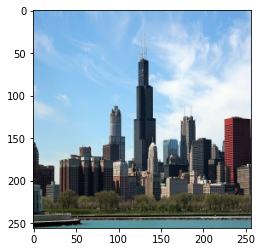

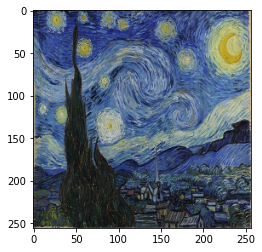

In [18]:
plt.imshow(tf.transpose(tf_c,[0,2,3,1])[0])
plt.figure()
plt.imshow(tf.transpose(tf_s,[0,2,3,1])[0])

In [19]:
print_public_attributes(tf_encoder)

c4_1 = tf_c
s4_1 = tf_s
for i in range(2):
    c4_1, c5_1 = itemgetter('out4_1', 'out5_1')(
        tf_encoder(image=c4_1))
    s4_1, s5_1 = itemgetter('out4_1', 'out5_1')(
        tf_encoder(image=s4_1))

    c_tfm = itemgetter('c_tfm')(
        tf_trfm(c4_1=c4_1,s4_1=s4_1, c5_1=c5_1, s5_1=s5_1))

    c_stylized = itemgetter('c_stylized')(
        tf_decoder(c_tfm=c_tfm))

    c4_1 = c_stylized#.detach().clone()
    s4_1 = tf_s#.detach().clone()
    c4_1 = tf.clip_by_value(c4_1,0,1)


['gen_tensor_dict', 'graph_debug_info', 'handler_variables', 'handlers', 'initializer_dict', 'outputs', 'signatures', 'tensorflow_git_version', 'tensorflow_version']


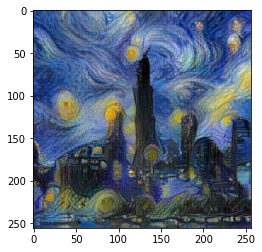

In [20]:
plt.imshow(tf.transpose(c4_1,[0,2,3,1])[0])

The error: `Error: Cannot infer the missing size in [-1,0] when there are 0 elements` was fixed by downloading onnx-tf directly from their repo and installing. Also needed to download cmake for windows and also, this is probably not important, I set `opset` param on torch onnx export to 10, instead from 11.

In [21]:
print_public_attributes(tf_trfm.signatures['serving_default'])
tf_trfm.signatures['serving_default'].structured_input_signature

['add_gradient_functions_to_graph', 'add_to_graph', 'captured_inputs', 'function_def', 'graph', 'inputs', 'name', 'output_dtypes', 'output_shapes', 'outputs', 'pretty_printed_signature', 'replace_capture_with_deferred_capture', 'set_external_captures', 'structured_input_signature', 'structured_outputs', 'trainable_variables', 'variables']


((),
 {'c4_1': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='c4_1'),
  'c5_1': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='c5_1'),
  's4_1': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='s4_1'),
  's5_1': TensorSpec(shape=(1, 512, None, None), dtype=tf.float32, name='s5_1')})

In [22]:
print(tf_trfm(
    c4_1=tf.random.normal([1,512,64, 64]),
    c5_1=tf.random.normal([1,512,32,  32]),
    s4_1=tf.random.normal([1,512,64, 64]),
    s5_1=tf.random.normal([1,512,32,  32]),
)['c_tfm'].shape)

tf.nest.map_structure(tf.shape,tf_encoder(
    image=tf.random.normal([1,3,512,512]),
))

(1, 512, 64, 64)


{'out4_1': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 512,  64,  64])>,
 'out5_1': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 512,  32,  32])>}

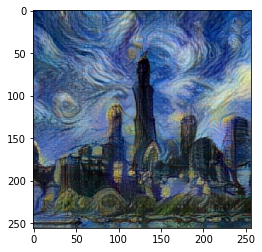

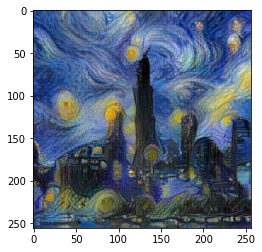

In [23]:
# @tf.function(
#     # jit_compile=True,
#     input_signature=[tf.TensorSpec([1,3,512,512],tf.float32,'image'),]
# )
def encode_tf(image):
    x = tf_encoder(image=image)
    # c4_1 = tf.reshape(x['out4_1'],[1,512,64,64])
    # c5_1 =  tf.reshape(x['out5_1'],[1,512,32,32])
    return x['out4_1'], x['out5_1']

# @tf.function(
#     # jit_compile=True,
#     input_signature=[tf.TensorSpec([1,512,64,64],tf.float32,'c_tfm'),]
# )
def decode_tf(c_tfm):
    x = tf_decoder(c_tfm=c_tfm)
    # c4_1 = tf.reshape(x['out4_1'],[1,512,64,64])
    # c5_1 =  tf.reshape(x['out5_1'],[1,512,32,32])
    return x['c_stylized']

# @tf.function(
#     # jit_compile=True,
#     input_signature=[
#         tf.TensorSpec([1,512,64,64],tf.float32,'c4_1'),
#         tf.TensorSpec([1,512,64,64],tf.float32,'s4_1'),
#         tf.TensorSpec([1,512,32,32],tf.float32,'c5_1'),
#         tf.TensorSpec([1,512,32,32],tf.float32,'s5_1'),
#     ]
# )
def trfm_tf(c4_1, s4_1, c5_1, s5_1):
    x = tf_trfm(c4_1=c4_1, s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
    # c_tfm = tf.reshape(x['c_tfm'],[1, 512, 64, 64])
    return x['c_tfm']


class TFStylize(tf.Module):
    # @tf.function(
    #     input_signature=[
    #         tf.TensorSpec(PT_IMG_SIZE,tf.float32,'content'),
    #         tf.TensorSpec(PT_IMG_SIZE,tf.float32,'style'),
    #         tf.TensorSpec([],tf.int32,'iters')
    #     ]
    # )
    def __call__(self, content, style, iters):
        
        i = tf.constant(0, dtype=tf.int32)
        # c_stylized = tf.zeros(PT_IMG_SIZE)
        while tf.less(i, iters):
            # tf.print('iter',i)
            # tf.print('encode content...')
            
            c4_1, c5_1 = encode_tf(content)
            # tf.print('encode style...')
            
            s4_1, s5_1 = encode_tf(style)
            # tf.print(tf.nest.map_structure(tf.shape,(c4_1, s4_1, c5_1, s5_1)))
            # tf.print('transform both...')
            c_tfm = trfm_tf(c4_1=c4_1, s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
            
            # tf.print('decode result')
            c_stylized = decode_tf(c_tfm=c_tfm)
            
            # tf.print('reshape and update content')
            content = tf.reshape(tf.clip_by_value(c_stylized,0,1),tf.shape(content))
            i += 1
        # tf.print('return')
        return tf.clip_by_value(content,0,1)
    
tfs = TFStylize()

plt.imshow(tf.transpose(tfs(tf_c, tf_s, 1),[0,2,3,1])[0])
plt.figure()
plt.imshow(tf.transpose(tfs(tf_c, tf_s, 2),[0,2,3,1])[0])

In [24]:
# tfs(tf.random.normal([1,3,512,512]),
#     tf.random.normal([1,3,512,512]),
#     2,);

In [26]:
@tf.function(
    input_signature=[
        tf.TensorSpec([None, None, 3],tf.float32,'content'),
        tf.TensorSpec([None, None, 3],tf.float32,'style'),
        tf.TensorSpec([],tf.int32,'iters'),
        tf.TensorSpec([],tf.int32,'max_resolution')
    ]
)
def signature(content, style, iters, max_resolution):
    # tf.print('orig shape', tf.shape(content), tf.shape(style))
    max_resolution = (max_resolution // 16) * 16
    orig_shape = tf.shape(content)[:2]
    
    content = tf.image.resize(content,
                              size=[max_resolution, max_resolution],
                              preserve_aspect_ratio=True)
    divisible_shape = (tf.shape(content)[:2] // 16) * 16
    content = tf.image.resize(content,divisible_shape)
    style = tf.image.resize(style, tf.shape(content)[:2])

    tf.debugging.assert_equal(tf.shape(content), tf.shape(style),f'Shapes are not equal. {content.shape}, {style.shape}')
    # tf.print('transformed shapes',tf.shape(content), tf.shape(style))

    content = tf.transpose(content, [2,0,1])[None,...]
    style = tf.transpose(style, [2,0,1])[None,...]

    # tf.print('shapes right before run',tf.shape(content), tf.shape(style))
    result = tf.transpose(tfs(content, style, iters)[0],[1,2,0])

    # tf.print('orig result shape', tf.shape(result))
    result = tf.image.resize(result,orig_shape,preserve_aspect_ratio=True)
    # tf.print('returning result shape', tf.shape(result))
    return {'result':result}
signature(
    tf.random.normal([356,256,3]),
    tf.random.normal([741,401,3]),
    tf.constant(1),
    tf.constant(256),
)

{'result': <tf.Tensor: shape=(356, 245, 3), dtype=float32, numpy=
 array([[[0.0000000e+00, 0.0000000e+00, 1.8010829e-02],
         [2.6564410e-02, 0.0000000e+00, 2.2632619e-02],
         [3.4928832e-02, 2.7572850e-03, 4.0634617e-02],
         ...,
         [5.0740319e-01, 3.5525757e-01, 3.4396854e-01],
         [4.5897609e-01, 3.1364304e-01, 2.6307061e-01],
         [2.4435058e-01, 1.5422580e-01, 8.5216179e-02]],
 
        [[0.0000000e+00, 0.0000000e+00, 7.5888326e-03],
         [1.5243345e-02, 0.0000000e+00, 9.5362160e-03],
         [1.9655064e-02, 1.1617774e-03, 2.2338362e-02],
         ...,
         [5.8527583e-01, 4.1927508e-01, 4.2272595e-01],
         [5.4368222e-01, 3.8721803e-01, 3.5486016e-01],
         [3.2563725e-01, 2.2634709e-01, 1.6175319e-01]],
 
        [[4.0447334e-04, 0.0000000e+00, 8.8118752e-03],
         [2.6127005e-02, 1.0758721e-02, 2.0728072e-02],
         [3.9592322e-02, 2.3598636e-02, 4.1069143e-02],
         ...,
         [5.8424759e-01, 4.4819075e-01, 4.6431

In [27]:
tf.saved_model.save(
    tfs,
    'model/weights/tf/full_model',
    signatures=dict(
        serving_default=signature
    )
)

INFO:tensorflow:Assets written to: model/weights/tf/full_model\assets


INFO:tensorflow:Assets written to: model/weights/tf/full_model\assets


In [28]:
tfs = tf.saved_model.load('model/weights/tf/full_model')

In [29]:
# print_public_attributes(tfs)
print_public_attributes(tfs.signatures['serving_default'])
tfs.signatures['serving_default'](content=tf.random.normal([340,391,3]), 
                                  style=tf.random.normal([740,500,3]),
                                  iters=tf.constant(1),
                                  max_resolution=tf.constant(256)
                                 )
tfs.signatures['serving_default'].structured_outputs

['add_gradient_functions_to_graph', 'add_to_graph', 'captured_inputs', 'function_def', 'graph', 'inputs', 'name', 'output_dtypes', 'output_shapes', 'outputs', 'pretty_printed_signature', 'replace_capture_with_deferred_capture', 'set_external_captures', 'structured_input_signature', 'structured_outputs', 'trainable_variables', 'variables']


{'result': TensorSpec(shape=(None, None, 3), dtype=tf.float32, name='result')}

In [30]:
tf_c_serve = tf.constant(np.array(c),'float') / 255.
tf_s_serve = tf.constant(np.array(s),'float') / 255.

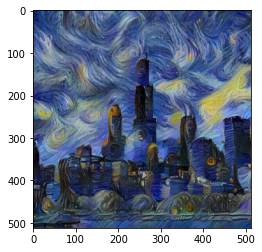

In [36]:
plt.imshow(tfs.signatures['serving_default'](
            content=tf_c_serve,
            style=tf_s_serve, 
            iters=tf.constant(2), 
            max_resolution=tf.constant(500)
)['result'])

In [35]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    model/weights/tf/full_model/ \
    static/model

Writing weight file static/model\model.json...
weight StatefulPartitionedCall/while/body/_71/while/PartitionedCall_2/PartitionedCall/Cast_21 with shape (1,) and dtype int64 was auto converted to the type int32
weight StatefulPartitionedCall/while/body/_71/while/PartitionedCall_2/PartitionedCall/Cast_20 with shape (1,) and dtype int64 was auto converted to the type int32
weight StatefulPartitionedCall/while/body/_71/while/PartitionedCall_2/PartitionedCall/SelectV2_9 with shape (1,) and dtype int64 was auto converted to the type int32
weight StatefulPartitionedCall/while/body/_71/while/PartitionedCall_2/PartitionedCall/zeros_16 with shape () and dtype int64 was auto converted to the type int32
weight StatefulPartitionedCall/while/body/_71/while/PartitionedCall_2/PartitionedCall/Const_21 with shape () and dtype int64 was auto converted to the type int32
weight StatefulPartitionedCall/while/body/_71/while/PartitionedCall_2/PartitionedCall/Shape_33 with shape (1,) and dtype int64 was auto c

In [ ]:
STOP

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model(
#     'experimental_tfsave',
#     ['serving_default'],
# )

# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.target_spec.supported_types = [tf.float16,tf.int32]
# converter.inference_output_type = [tf.float16]
# converter.representative_dataset 
# tflite_model = converter.convert()

In [ ]:
with open('static/model.tflite','wb') as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter('static/model.tflite',num_threads=-1,)

In [ ]:
interpreter.allocate_tensors()

In [ ]:
input_specs = interpreter.get_input_details()
input_specs

In [ ]:
output_specs = interpreter.get_output_details()
output_specs

In [ ]:
input_args = [tf.transpose(tf_s[0],[1,2,0]),
         tf.constant(2),
        tf.transpose(tf_c[0],[1,2,0]),]
for spec, arg in zip(input_specs,input_args):
    # print(spec['index'], arg)
    interpreter.set_tensor(
        spec['index'], arg
    )
interpreter.invoke()


In [ ]:
result = interpreter.get_tensor(output_specs[0]['index'])

In [ ]:
plt.imshow(result)

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    model/weights/tf/full_model/ \
    static/js_models/256

In [ ]:
# pip install tensorflowjs[wizard]